In [8]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

#Load LLM

In [9]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")

#Clause Analysis

In [14]:
from pydantic import BaseModel, Field

class ClauseMetadata(BaseModel):
    jurisdiction: str
    version: str
    last_update: str

In [ ]:
from typing_extensions import Optional, Dict, List
from langchain_community.vectorstores import Pinecone
from pinecone import ServerlessSpec
from langchain_ollama import OllamaEmbeddings
import json

class ClauseRetriever:
    def __init__(self, json_file_path: Optional[str] = None):
        self.pc = Pinecone()
        self.index_name = "cotract_clause"
        self.emmbedding = OllamaEmbeddings(model="llama3.2:1b")
        self.index = self.pc.Index(self.index_name)
        self.vectorstore = Pinecone(
            index= self.index,
            embedding= self.emmbedding,
            text_key="text",
        )
        if json_file_path:
            self._load_clauses(json_file_path)

    def _load_clauses(self, json_file_path: str):
        """Loads and extracts contract files from json file"""
        with open(json_file_path, "r") as file:
            self.contract_types = json.load(file)
        
        for contract_data in self.contract_types:
            self._index_contract_clause(contract_data)

    def _index_contract_clause(self, contract_data: Dict):
        """Index clauses for a specific  contract type"""
        contract_type = contract_data["contract_type"]

        vectors_to_insert = []
        for clause in contract_data["clauses"]:
            clauses_text = f"""
                Contract Type: {contract_type}
                Clause Title: {clause["clause_title"]}

                {clause["clause_text"]}
            """

            metadata = {
                "contract_type" : contract_type,
                "clause_title" : clause["clause_title"],
                "jurisdiction" : clause["metadata"]["jurisdiction"],
                "version" : clause["metadata"]["version"],
                "last_update" : clause["metadata"]["last_update"],
                "text" : clauses_text
            }

            vector = self.emmbedding.embed_query(clauses_text)

            vectors_to_upsert.append({
                "id": f"{contract_type}--{clause["clause_title"]}".lower().replace(" ", "-"),
                "values": vector,
                "metadata": metadata
            })

            if len(vectors_to_upsert) >= 100:
                self.index.upsert(vectors_to_insert)
                vectors_to_upsert = []

        if vectors_to_upsert:
            self.index.upsert(vectors_to_upsert)

    def get_clause_by_contract_type(
            self,
            contract_type = str,
            jurisdiction: Optional[str] = None,
            k: int = 5
    )-> List[Dict]:
        """Retrieve relevant clause based on the contract type and optional filters"""
        filter_dict = {"contract_type": contract_type}
        if jurisdiction:
            filter_dict["jurisdiction"] = jurisdiction
        
        query_text = f"Find clauses for {contract_type} contract"
        query_vector = self.emmbedding.embed_query(query_text)

        results = self.index.query(
            query_vector,
            vector=query_vector,
            top_k=k,
            filter=filter_dict,
            include_values=True,
            include_metadata=True
        )

        formatted_results = []
        for match in results["matches"]:
            formatted_results.append({
                "clause_title": match['metadata']["clause_title"],
                "clause_text": match['metadata']["text"],
                "metadata": match['metadata'],
                "relevance_score": match['score']
            })

        return formatted_results
    
    def search_clauses(self,
                       query: str,
                      contract_type: Optional[str] = None,
                      jurisdiction: Optional[str] = None,
                      k: int = 5) -> List[Dict]:
        """Search for clauses based on simantic score"""

        filter_dict = {}
        if contract_type:
            filter_dict["contract_type"] = contract_type
        if jurisdiction:
            filter_dict["jurisdiction"] = jurisdiction

        query_vector = self.emmbedding.embed_query(query)

        results = self.index.query(
            vector=query_vector,
            top_k=k,
            filter=filter_dict if filter_dict else None,
            include_values=True,
            include_metadata=True
        )
        formatted_results = []
        for match in results['matches']:
            formatted_results.append({
                "clause_title": match['metadata']["clause_title"],
                "clause_text": match['metadata']["text"],
                "metadata": match['metadata'],
                "relevance_score": match['score']
            })

        return formatted_results

#Load Clauses

In [12]:
clause_retriever = ClauseRetriever(r"D:\My Files\GitHub_Materials\GenAI_Agents\Business\clauses.json")

employment_clause = clause_retriever.get_clause_by_contract_type(
    contract_type="Employment Contract"
)

TypeError: Pinecone.__init__() missing 3 required positional arguments: 'index', 'embedding', and 'text_key'

#Contract Review

In [15]:
class ContractInfo(BaseModel):
    contract_type: str = Field(description="Type of contract")
    industry: Optional[str] = Field(description="Industry of identifiable")

In [16]:
class ContractReviewPlan(BaseModel):
    steps: List[str] = Field(description="Detailed steps for contract review")

In [18]:
class Modification(BaseModel):
    original_text: str = Field(description="Original contract text")
    suggested_text: str = Field(description="Suggestion modified")
    reason: str = Field(description="Reason for modification")

In [19]:
from typing_extensions import TypedDict, Annotated
import operator

class ContractReviewState(TypedDict):
    contract_text: str
    primary_objective: str
    specific_focus: Optional[str]
    contract_info: ContractInfo
    review_plan: ContractReviewPlan
    current_step: int
    modifications: Annotated[List[Modification], operator.add]
    clause_modifications: Annotated[List[Modification], operator.add]
    sections: Annotated[List[str], operator.add]
    clause_analysis: Annotated[List[str], operator.add]
    clauses: Annotated[List[str], operator.add]
    final_report: str

In [20]:
class StepAnalysis(BaseModel):
    modifications: List[Modification] = Field(default_factory=list, description="List of suggested modifications")
    analysis: str = Field(description="Analysis from this role's perspective")

#Contract Review Nodes

In [21]:
from langchain_core.messages import HumanMessage, SystemMessage

def classify_contract(state: ContractReviewState):
    """Node to classify the contract type and industry"""
    system_prompt = """Analyze the provided contract and determine:
    1. The type of contract (e.g., Employment, NDA, License Agreement)
    2. The industry it belongs to (if clear from the context)."""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Contract text:\n{state['contract_text']}")
    ]

    contract_info = llm.with_structured_output(ContractInfo).invoke(messages)
    return {"contract_info": contract_info}

In [22]:
def retrieve_clauses(state: ContractReviewState):
    """Node to retrieve clauses based on contract type and filter for relevancy"""
    contract_type = state['contract_info'].contract_type

    try:
        general_clauses = clause_retriever.get_clause_by_contract_type(
            contract_type="General Clauses",
            k=10  
        )

        specific_clauses = clause_retriever.get_clause_by_contract_type(
            contract_type=contract_type,
            k=10  
        )

        system_prompt = f"""You are a legal clause relevancy analyzer.
        For each clause, determine if it is relevant for a {contract_type}.
        Respond with either "RELEVANT" or "NOT RELEVANT".
        Base your decision on how essential and appropriate the clause is for this type of contract."""

        filtered_specific_clauses = []
        for clause in specific_clauses:
            messages = [
                SystemMessage(content=system_prompt),
                HumanMessage(content=f"Clause Title: {clause['clause_title']}\n\nClause Text: {clause['clause_text']}")
            ]

            response = llm.invoke(messages).content.strip().upper()
            if response == "RELEVANT":
                filtered_specific_clauses.append(clause)

        formatted_clauses = []

        # Add ALL General Clauses first
        for clause in general_clauses:
            formatted_clause = f"""### {clause['clause_title']}

            {clause['clause_text']}
            """
            formatted_clauses.append(formatted_clause)

        for clause in filtered_specific_clauses:
            formatted_clause = f"""### {clause['clause_title']}

            {clause['clause_text']}
            """
            formatted_clauses.append(formatted_clause)

        return {"clauses": formatted_clauses,
                 "current_step": 0}
    except Exception as e:
        error_message = f"Error retrieving clauses: {str(e)}"
        return {"clauses": [error_message]}

In [23]:
def execute_step_clause(state: ContractReviewState):
    """Node to verify if each clause is clearly represented in the contract"""

    clause = state['clauses'][0]

    system_prompt = f"""You are a Legal Clause Clarity Analyst.
    Review the contract and determine if the following clause is clearly represented:

    {clause}

    Guidelines for your review:
    1. Check if the clause's key elements are present in the contract
    2. Verify if the language is clear and unambiguous
    3. Suggest modifications only if the clause is missing or unclear"""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=state['contract_text'])
    ]

    step_result = llm.with_structured_output(StepAnalysis).invoke(messages)
    clause_summary = f"### Clause Analysis\n{step_result.analysis}"

    return_dict = {
        "clause_analysis": [clause_summary]
    }

    if step_result.modifications:
        return_dict["clause_modifications"] = step_result.modifications

    return return_dict

In [24]:
def create_review_plan(state: ContractReviewState):
    """Node to create a detailed review plan based on different legal roles/perspectives"""

    system_prompt = """You are a legal contract review planner.
    Create a review plan where each step represents a different legal role/perspective for reviewing the contract.

    Context:
    - Contract Type: {contract_type}
    - Industry: {industry}
    - Primary Objective: {objective}
    - Specific Focus: {focus}

    Each step should be a specific role perspective, such as:
    - Employment Law Specialist Review
    - Intellectual Property Counsel Review
    - Compliance Officer Review
    - Financial Terms Specialist Review
    - Risk Management Review
    - Data Privacy Officer Review

    Do not include generic steps or specific clause analysis - that will happen during execution.""".format(
        contract_type=state['contract_info'].contract_type,
        industry=state['contract_info'].industry or "Not specified",
        objective=state['primary_objective'],
        focus=state['specific_focus'] or "Not specified"
    )

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Contract text:\n{state['contract_text']}\n\nGenerate a role-based review plan.")
    ]

    review_plan = llm.with_structured_output(ContractReviewPlan).invoke(messages)
    return {
        "review_plan": review_plan,
        "current_step": 0
    }

In [25]:
def execute_step(state: ContractReviewState):
    """Node to execute each step of the review plan with specific analysis"""

    role = state['review_plan'][0]

    system_prompt = f"""You are a {role}.
    Review the contract from your professional perspective.

    Guidelines for your review:
    1. Identify specific sections that fall under your expertise
    2. Analyze those sections in detail
    3. Suggest concrete modifications where necessary

    Your response should include:
    1. analysis: A detailed explanation of your review findings
    2. modifications: A list of suggested changes, each containing:
       - original_text: The exact text to be modified
       - suggested_text: Your proposed replacement
       - reason: Clear reasoning for the change based on your role

    You may suggest multiple modifications or none if appropriate."""

    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=state['contract_text'])
    ]

    step_result = llm.with_structured_output(StepAnalysis).invoke(messages)
    section_summary = f"### {role}\n{step_result.analysis}"

    return {
        "modifications": step_result.modifications,
        "sections": [section_summary]
    }

In [26]:
def generate_final_report(state: ContractReviewState):
    """Node to generate the final report and summary."""
    # Extract relevant data from the state
    contract_text = state["contract_text"]
    primary_objective = state["primary_objective"]
    specific_focus = state.get("specific_focus", "Not specified")
    contract_type = state["contract_info"].contract_type
    industry = state["contract_info"].industry or "Not specified"
    review_plan = state["review_plan"]
    clause_modifications = state["clause_modifications"]
    planner_modifications = state["modifications"]
    sections = state["sections"]
    clause_analysis = state["clause_analysis"]
    clauses = state["clauses"]

    # Combine all modifications for LLM processing
    all_modifications = clause_modifications + planner_modifications

    # Prepare the system prompt
    system_prompt = (
        "You're a modifications reviewer, you get a list of modifications.\n"
        "class Modification(BaseModel):\n"
        "  original_text: str = Field(description='Original contract text')\n"
        "  suggested_text: str = Field(description='Suggested modification')\n"
        "  reason: str = Field(description='Reason for modification')\n\n"
        "Please summarize them, mostly focusing on the reason and explain it from a legal expert's point of view.\n\n"
        "The modifications:\n"
        f"{all_modifications}\n"
    )

    # Generate the messages
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content="Please summarize the modifications")
    ]

    # Invoke the LLM
    try:
        review_plan = llm.invoke(messages)
        modification_summary = review_plan.content
    except Exception as e:
        modification_summary = f"Error generating summary: {str(e)}"

    # Generate the report
    report = "\n".join([
        "===============================================",
        "                  Contract Review Report       ",
        "===============================================",
        "",
        "Contract Overview",
        "-----------------",
        f"Primary Objective: {primary_objective}",
        f"Specific Focus: {specific_focus}",
        "",
        f"Contract Type: {contract_type}",
        f"Industry: {industry}",
        "",
        "Sections and Clauses Analyzed:",
        "------------------------------",
        f"Total Sections Reviewed: {len(sections)}",
        f"Total Clauses Analyzed: {len(clauses)}",
        "",
        "Key Findings and Analysis:",
        "--------------------------",
        "\n".join(f"- {analysis}" for analysis in clause_analysis),
        "",
        "Highlights of Suggested Modifications:",
        "--------------------------------------",
        modification_summary,
        "",
        "Compliance and Risk Assessment:",
        "-------------------------------",
        "- The contract has been reviewed for compliance with relevant laws and regulations.",
        "- Potential risks and mitigation strategies have been identified.",
        "- Tailored suggestions have been provided to enhance the contract’s effectiveness.",
        "",
        "Final Notes:",
        "------------",
        "Please ensure all suggested modifications are incorporated and reviewed by a legal expert before finalizing the contract.",
        "",
        "===============================================",
        "                  End of Report               ",
        "===============================================",
    ])

    return {"final_report": report}

#Parallel Work

In [27]:
from langgraph.constants import Send


def continue_to_clauses_check_execute(state: ContractReviewState):
    return [Send("execute_step_clause", {"contract_text": state["contract_text"], "clauses": c}) for c in state["clauses"]]


def continue_to_plan_check_execute(state: ContractReviewState):
    return [Send("execute_step", {"contract_text": state["contract_text"], "review_plan": step}) for step in state["review_plan"].steps]

#Create Graph

In [28]:
from langgraph.graph import StateGraph, START, END
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver

# Create the graph
builder = StateGraph(ContractReviewState)

# Add nodes
builder.add_node("classify_contract", classify_contract)
builder.add_node("retrieve_clauses", retrieve_clauses)
builder.add_node("execute_step_clause", execute_step_clause)
builder.add_node("create_review_plan", create_review_plan)
builder.add_node("execute_step", execute_step)
builder.add_node("generate_final_report", generate_final_report)

# Add edges
builder.add_edge(START, "classify_contract")
builder.add_edge("classify_contract", "retrieve_clauses")

builder.add_conditional_edges("retrieve_clauses", continue_to_clauses_check_execute, ["execute_step_clause"])
builder.add_edge("execute_step_clause", "create_review_plan")

builder.add_conditional_edges("create_review_plan", continue_to_plan_check_execute, ["execute_step"])
builder.add_edge("execute_step", "generate_final_report")

builder.add_edge("generate_final_report", END)

# Compile the graph

# Create the checkpointer
checkpointer = MemorySaver()

# Create memory store
in_memory_store = InMemoryStore()

# Compile graph with both checkpointer and store
graph = builder.compile(
    checkpointer=checkpointer,
    store=in_memory_store
)

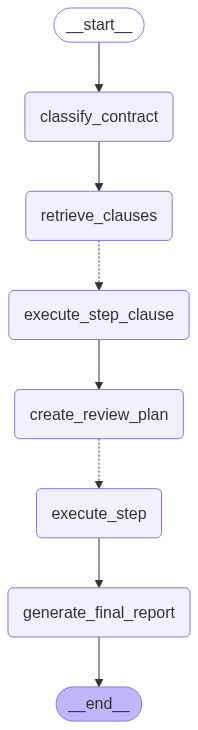

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

#Test Case

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import PyPDF2
import docx

# Function to extract text from a PDF
def extract_text_from_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
    return text

# Function to extract text from a DOCX file
def extract_text_from_docx(file_path):
    doc = docx.Document(file_path)
    text = "\n".join([paragraph.text for paragraph in doc.paragraphs])
    return text

# Variables to store file content and user inputs
uploaded_file_path = None
contract = ""
primary_objective = ""
specific_focus = ""

# Callback function to handle file upload
def handle_file_upload(change):
    global uploaded_file_path
    uploaded_file = change['new']
    for file_name, file_info in uploaded_file.items():
        uploaded_file_path = file_name
        with open(file_name, 'wb') as f:
            f.write(file_info['content'])
        print(f"File {file_name} uploaded successfully!")

# File upload widget
upload_widget = widgets.FileUpload(accept='.pdf,.docx', multiple=False)
upload_widget.observe(handle_file_upload, names='value')

# Text inputs for primary_objective and specific_focus
primary_objective_input = widgets.Text(
    description="Primary Objective:",
    placeholder="Enter the primary objective",
)

specific_focus_input = widgets.Text(
    description="Specific Focus:",
    placeholder="Enter the specific focus",
)

# Button to save inputs and extract file content
def save_inputs_and_extract_file_content(_):
    global contract, primary_objective, specific_focus

    # Check if a file has been uploaded
    if not uploaded_file_path:
        print("Please upload a file before saving inputs!")
        return

    # Determine file type and extract text
    if uploaded_file_path.endswith('.pdf'):
        contract = extract_text_from_pdf(uploaded_file_path)
    elif uploaded_file_path.endswith('.docx'):
        contract = extract_text_from_docx(uploaded_file_path)
    else:
        print("Unsupported file format. Please upload a PDF or DOCX file.")
        return

    # Save user inputs
    primary_objective = primary_objective_input.value
    specific_focus = specific_focus_input.value

    # Display the results
    print("\n--- Results ---")
    print(f"Extracted Contract Text (first 500 chars):\n{contract[:500]}...")  # Showing a snippet for clarity
    print(f"Primary Objective: {primary_objective}")
    print(f"Specific Focus: {specific_focus}")

save_button = widgets.Button(description="Save & Extract")
save_button.on_click(save_inputs_and_extract_file_content)

# Display widgets
display(upload_widget)
display(primary_objective_input)
display(specific_focus_input)
display(save_button)


In [ ]:
input_state = {
    "contract_text": contract,
    "primary_objective": primary_objective,
    "specific_focus": specific_focus,
}
# Update the config structure
config = {
    "thread_id": "1",  # String instead of nested dict
    "user_id": "user_123"
}

result = graph.invoke(input_state, config)
print(result['final_report'])